In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# Function to compute RSI for a given series and window
def compute_RSI(series, window):
    delta = series.diff()
    gain = delta.clip(lower=0)
    loss = -delta.clip(upper=0)
    avg_gain = gain.rolling(window=window, min_periods=window).mean()
    avg_loss = loss.rolling(window=window, min_periods=window).mean()
    RS = avg_gain / (avg_loss + 1e-10)  # Avoid division by zero
    RSI = 100 - (100 / (1 + RS))
    return RSI

# Function to build the RSI strategy with long and short positions
def rsi_strategy(data, window, oversold=30, overbought=80):
    df = data.copy()
    df['RSI'] = compute_RSI(df['Close'], window)

    # Generate trading signals: +1 for long, -0.5 for short
    df['Signal'] = 0
    df['Signal'] = df['Signal'].astype(float)
    df.loc[df['RSI'] < oversold, 'Signal'] = 1  # Long
    df.loc[df['RSI'] > overbought, 'Signal'] = -0.5  # Short (Modified from -1 to -0.5)

    # Carry forward the last signal until a new signal appears
    df['pos'] = df['Signal'].replace(to_replace=0, method='ffill').fillna(0)

    # Calculate daily returns and strategy returns
    df['Returns'] = df['Close'].pct_change()
    df['Strategy_Returns'] = df['pos'].shift(1) * df['Returns']
    df['Strategy_Returns'].fillna(0, inplace=True)

    # Compute cumulative returns
    test_df = df.loc['2024-03-01':]
    test_df['Cumulative_Return_Strategy'] = (1 + test_df['Strategy_Returns']).cumprod()
    total_return = test_df['Cumulative_Return_Strategy'].iloc[-1]
    # test_df.to_csv('Predictions of ' + stock + '.csv')

    return total_return, test_df

# Function to plot strategy results, including price, position, and cumulative returns
def plot_rsi_strategy(df, best_window):
    fig, ax1 = plt.subplots(figsize=(12, 6))

    # Plot actual price
    ax1.set_xlabel('Date')
    ax1.set_ylabel('Price', color='tab:blue')
    ax1.plot(df.index, df['Close'], label='Close Price', color='tab:blue', alpha=0.6)
    ax1.tick_params(axis='y', labelcolor='tab:blue')

    # Plot position (Long/Short) on secondary axis
    ax2 = ax1.twinx()
    ax2.set_ylabel('Position', color='tab:gray')
    ax2.plot(df.index, df['pos'], label='Position', color='red')
    ax2.tick_params(axis='y', labelcolor='tab:gray')

    # Add legends
    ax1.legend(loc='upper left')
    ax2.legend(loc='upper right')

    plt.title(f'RSI Strategy - Price & Positions (Window {best_window})')
    plt.show()

    # Plot cumulative returns separately
    plt.figure(figsize=(12, 6))
    plt.plot(df.index, df['Cumulative_Return_Strategy'], label=f'RSI Strategy (Window {best_window})', color='green')
    plt.xlabel('Date')
    plt.ylabel('Cumulative Return')
    plt.title('RSI Strategy Cumulative Return')
    plt.legend()
    plt.grid(True)
    plt.show()

# Function to perform grid search over RSI windows
def find_best_rsi_window(df, window_range):
    results = {}
    for window in window_range:
        total_return, _ = rsi_strategy(df, window)
        results[window] = total_return
    best_window = max(results, key=results.get)
    _, best_strategy_df = rsi_strategy(df, best_window)
    return best_window, results, best_strategy_df


In [4]:
def rsi_strategy_with_plot(df):
    # Finding Best RSI Window
    window_range = range(5, 61, 3)
    best_window, results, best_strategy_df = find_best_rsi_window(df, window_range)

    # Plotting Stock Prices and Positions
    plot_rsi_strategy(best_strategy_df, best_window)

    # Print the best RSI window and corresponding return
    print("RSI Window\tTotal Return")
    for w, ret in results.items():
        print(f"{w}\t\t{ret:.2%}")
    print(f"\nBest RSI window for {stock}: {best_window} with Total Return: {results[best_window]:.2%}")

C:\Users\ASUS\AppData\Local\Temp\ipykernel_9400\1310329989.py:24: FutureWarning: The 'method' keyword in Series.replace is deprecated and will be removed in a future version.
  df['pos'] = df['Signal'].replace(to_replace=0, method='ffill').fillna(0)
C:\Users\ASUS\AppData\Local\Temp\ipykernel_9400\1310329989.py:27: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  df['Returns'] = df['Close'].pct_change()
C:\Users\ASUS\AppData\Local\Temp\ipykernel_9400\1310329989.py:29: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].met

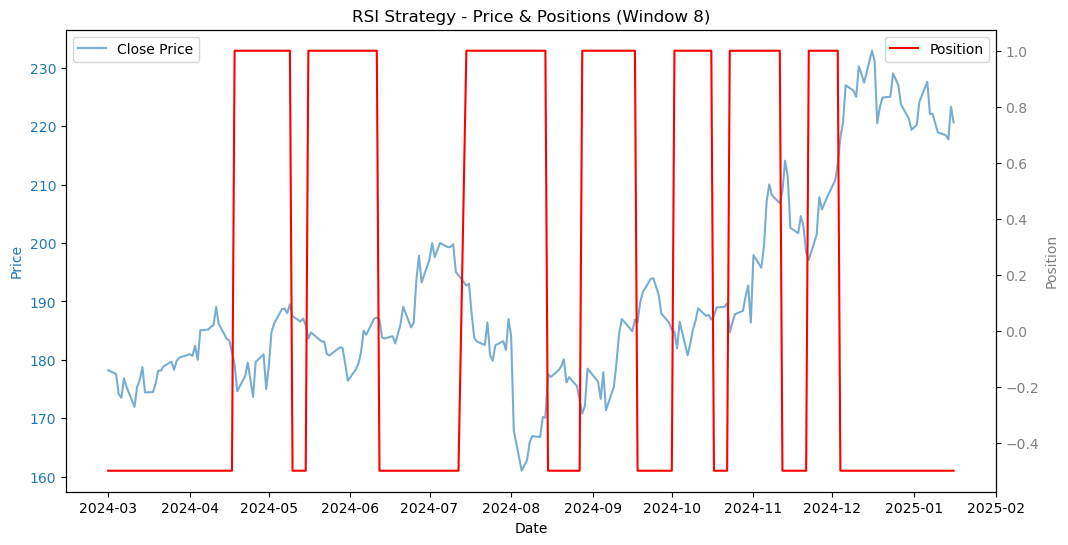

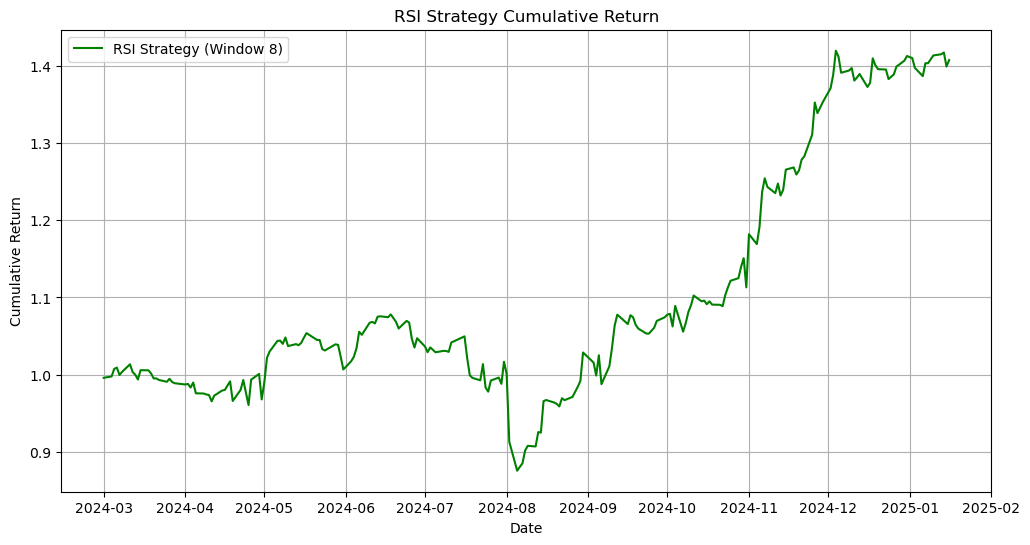

RSI Window	Total Return
5		100.68%
8		140.74%
11		100.70%
14		86.69%
17		134.83%
20		131.42%
23		131.42%
26		137.04%
29		100.00%
32		100.00%
35		100.00%
38		100.00%
41		100.00%
44		100.00%
47		100.00%
50		100.00%
53		100.00%
56		100.00%
59		100.00%

Best RSI window for AMZN: 8 with Total Return: 140.74%


In [10]:
stock = 'AMZN'
df = pd.read_csv('../'+ stock + '/' + stock +'.csv', parse_dates=['Date'], index_col='Date')
df.dropna()

rsi_strategy_with_plot(df)

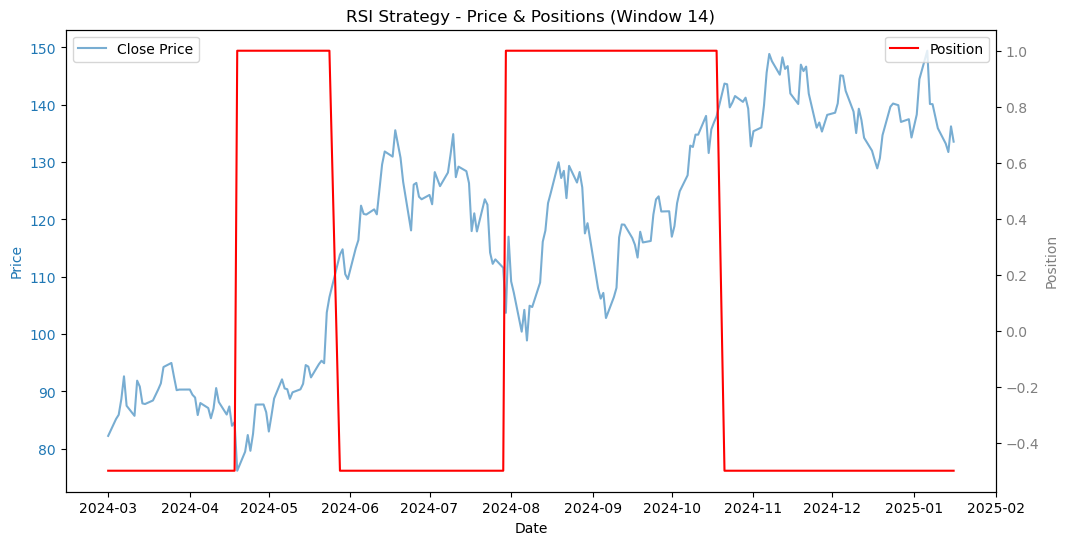

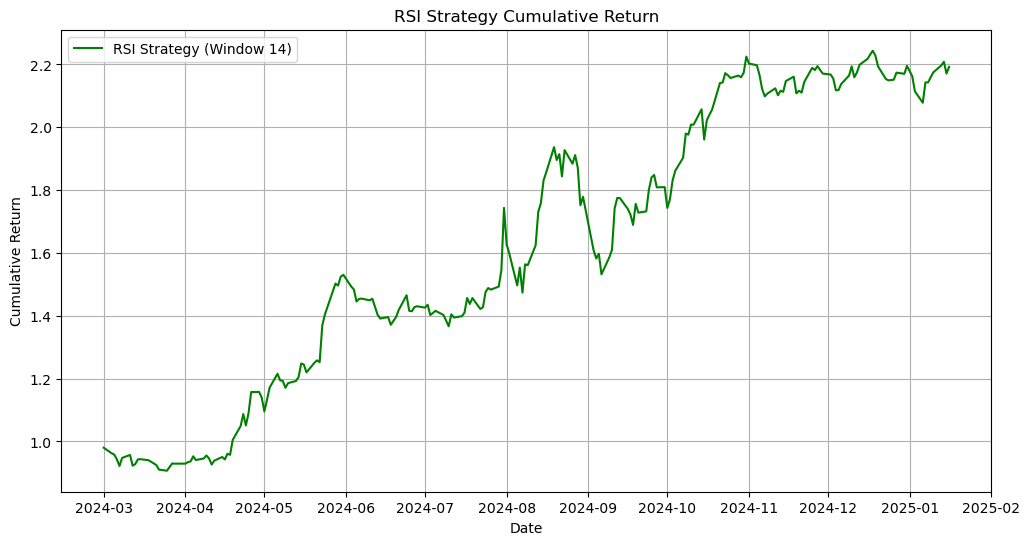

RSI Window	Total Return
5		161.06%
8		126.49%
11		177.12%
14		219.24%
17		117.34%
20		86.93%
23		86.58%
26		92.69%
29		91.05%
32		93.19%
35		100.00%
38		100.00%
41		100.00%
44		100.00%
47		100.00%
50		100.00%
53		100.00%
56		100.00%
59		100.00%

Best RSI window for NVDA: 14 with Total Return: 219.24%


In [ ]:
stock = 'NVDA'
df = pd.read_csv('../'+ stock + '/' + stock +'.csv', parse_dates=['Date'], index_col='Date')
df.dropna()

rsi_strategy_with_plot(df)

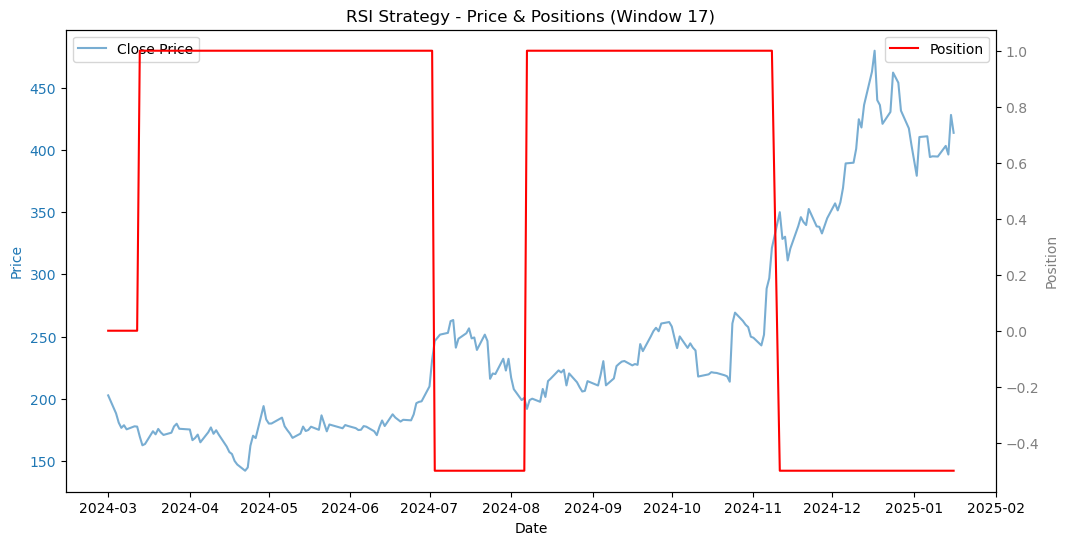

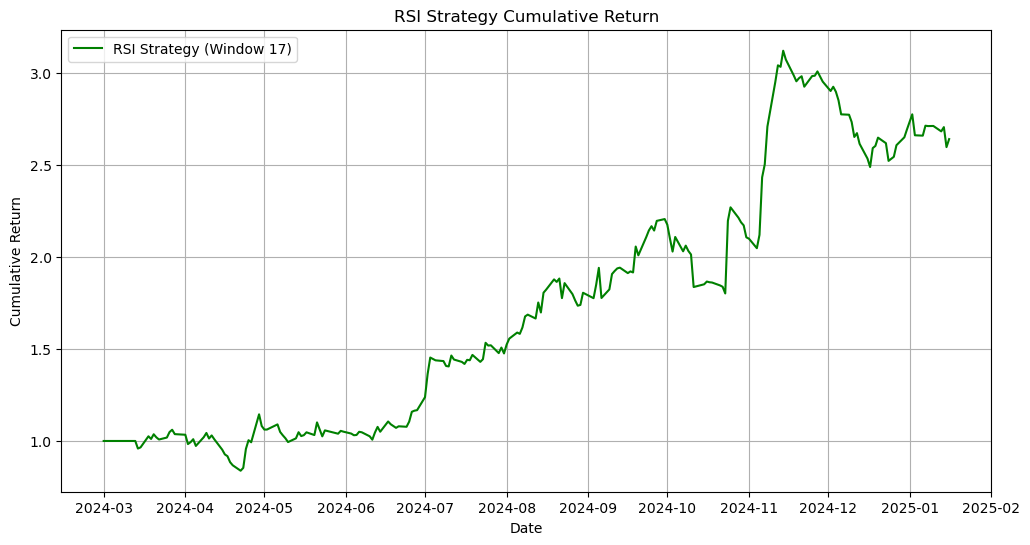

RSI Window	Total Return
5		138.92%
8		63.32%
11		152.19%
14		239.31%
17		264.22%
20		193.84%
23		69.84%
26		70.58%
29		70.78%
32		100.00%
35		100.00%
38		100.00%
41		100.00%
44		100.00%
47		100.00%
50		100.00%
53		100.00%
56		100.00%
59		100.00%

Best RSI window for TSLA: 17 with Total Return: 264.22%


In [ ]:
stock = 'TSLA'
df = pd.read_csv('../'+ stock + '/' + stock +'.csv', parse_dates=['Date'], index_col='Date')
df.dropna()

rsi_strategy_with_plot(df)

In [ ]:
stock = ''
df = pd.read_csv(stock + '.csv', parse_dates=['Date'], index_col='Date')
df.dropna()

rsi_strategy_with_plot(df)